In [117]:
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import pertpy as pt
from scipy.stats import spearmanr, pearsonr

from utils import scanpy_setup

sc.set_figure_params(dpi=100, frameon=False, facecolor=None)

Run Augur for cell type prioritization.

In [43]:
adata = pt.dt.bhattacherjee()
ag_rfc = pt.tl.Augur("random_forest_classifier")
loaded_data = ag_rfc.load(
    adata, condition_label="Maintenance_Cocaine", treatment_label="withdraw_15d_Cocaine"
)

Filtering samples with Maintenance_Cocaine and withdraw_15d_Cocaine labels.

In [13]:
adata

withdraw_15d_Cocaine    6623
withdraw_48h_Cocaine    3337
Maintenance_Cocaine     2976
Name: label, dtype: int64

In [8]:
h_adata, h_results = ag_rfc.predict(loaded_data, random_state=None, n_threads=4)

display(h_results["summary_metrics"])

Set smaller span value in the case of a `segmentation fault` error.

Set larger span in case of svddc or other near singularities error.

Output()

                     Astro  Microglia  Excitatory      Endo     Oligo  \
mean_augur_score  0.780522   0.757075    0.602041  0.576973  0.801247   
mean_auc          0.780522   0.757075    0.602041  0.576973  0.801247   
mean_accuracy     0.624176   0.590989    0.569158  0.535201  0.639963   
mean_precision    0.796136   0.677556    0.591734  0.553564  0.778810   
mean_f1           0.429302   0.326065    0.534801  0.463758  0.470658   
mean_recall       0.332698   0.232698    0.533016  0.454762  0.368095   

                       OPC  Inhibitory  NF Oligo  
mean_augur_score  0.729909    0.649989  0.629626  
mean_auc          0.729909    0.649989  0.629626  
mean_accuracy     0.604396    0.601905  0.570513  
mean_precision    0.715045    0.657316  0.591606  
mean_f1           0.407386    0.529419  0.488113  
mean_recall       0.315556    0.487619  0.467143  


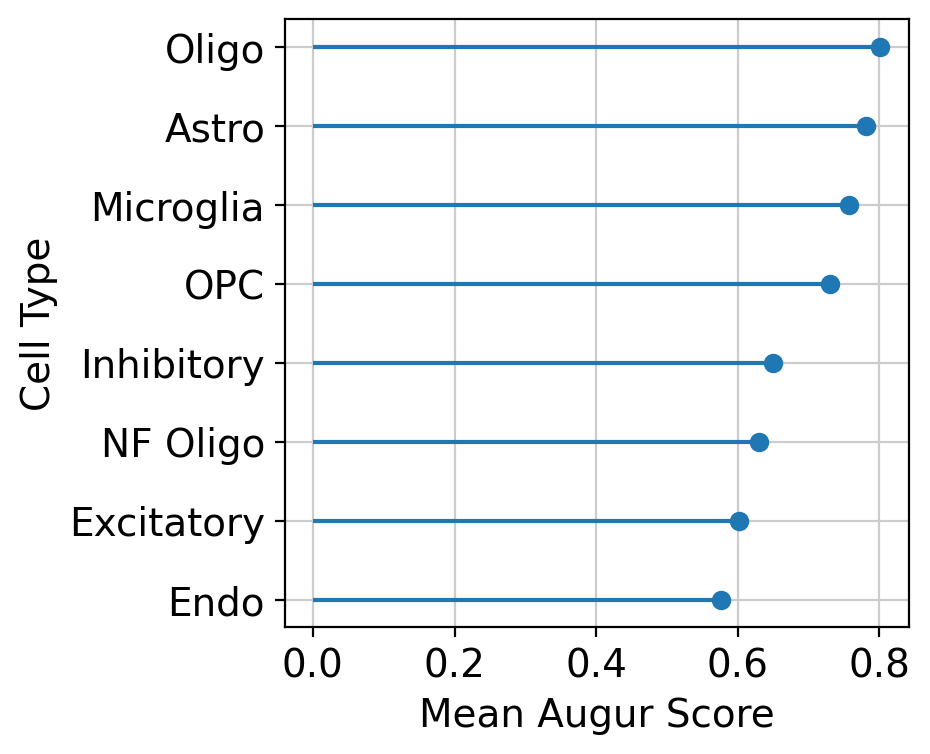

In [9]:
lollipop = pt.pl.ag.lollipop(h_results)

Instead of using Augur, calculate the distance between control and perturbed per cell type.

In [44]:
scanpy_setup(adata)

In [128]:
distance = pt.tl.Distance(metric='mse')

dist = {}
for ct in adata.obs.cell_type.unique():
    subset = adata[adata.obs.cell_type == ct]
    dist[ct] = distance(
        subset[subset.obs.label == 'withdraw_15d_Cocaine'].X,
        subset[subset.obs.label == 'Maintenance_Cocaine'].X
    )
df = pd.DataFrame.from_dict(dist, orient='index')
df.columns = ['MSE']

Text(0.5, 0, 'MSE, maintenance vs. 15d')

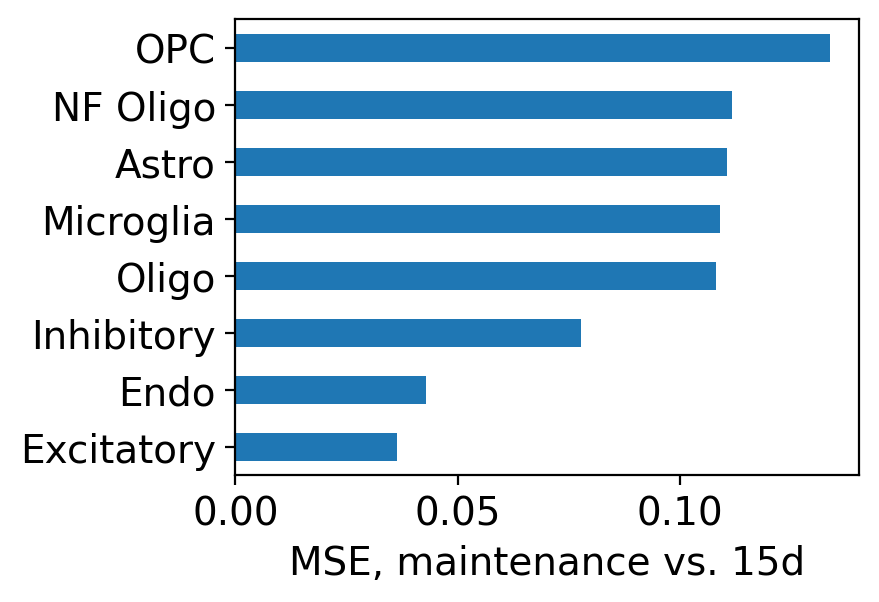

In [130]:
df.sort_values('MSE').plot.barh(legend=None, figsize=(4, 3))
plt.grid(None)
plt.xlabel('MSE, maintenance vs. 15d')

In [132]:
res = pd.concat([
    h_results["summary_metrics"].T[['mean_augur_score']],
    df
], axis=1).sort_values('MSE')
res

,mean_augur_score,MSE
Excitatory,0.602041,0.036412
Endo,0.576973,0.042914
Inhibitory,0.649989,0.077748
Oligo,0.801247,0.108115
Microglia,0.757075,0.109123
Astro,0.780522,0.110561
NF Oligo,0.629626,0.111793
OPC,0.729909,0.133753


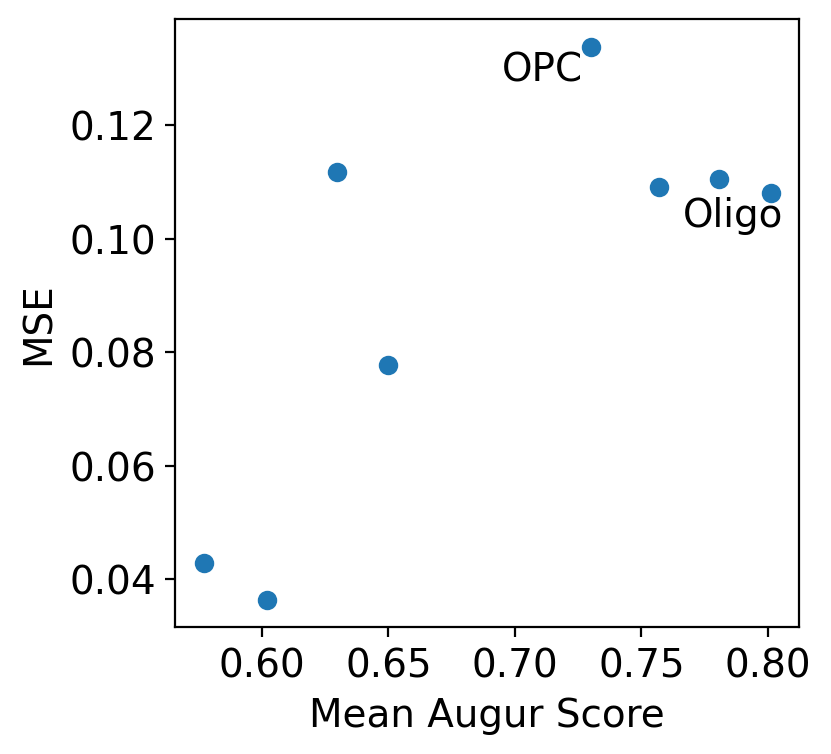

In [142]:
plt.figure(figsize=(4,4))
rho = spearmanr(res['mean_augur_score'].values, res['MSE'].values)[0]
plt.scatter(res['mean_augur_score'], res['MSE'], label=f"Spearman: {rho:.2f}")

offset_x = .035
offset_y = .006
for i, txt in enumerate(res.index):
    if txt in ['OPC', 'Oligo']:
        plt.annotate(txt, (res['mean_augur_score'].iloc[i]-offset_x, res['MSE'].iloc[i]-offset_y))

plt.xlabel('Mean Augur Score')
plt.ylabel('MSE')
plt.grid(None)
# plt.legend()
plt.show()

In [125]:
print(spearmanr(res['mean_augur_score'].values, res['MSE'].values)[0])
pearsonr(res['mean_augur_score'].values, res['MSE'].values)[0]

0.2142857142857143


0.3712953363416326

And now the differential.

In [104]:
distance = pt.tl.Distance(metric='mse')

dist2 = {}
for ct in adata.obs.cell_type.unique():
    subset = adata[adata.obs.cell_type == ct]
    dist2[ct] = distance(
        subset[subset.obs.label == 'withdraw_48h_Cocaine'].X,
        subset[subset.obs.label == 'Maintenance_Cocaine'].X
    )

In [105]:
diff = pd.concat([
    pd.DataFrame.from_dict(dist, orient='index').rename(columns={0:'15d'}),
    pd.DataFrame.from_dict(dist2, orient='index').rename(columns={0:'48h'})
], axis=1)
diff

,15d,48h
Astro,0.110561,0.034515
Microglia,0.109123,0.019856
Excitatory,0.036412,0.012765
Endo,0.042914,0.021383
Oligo,0.108115,0.027148
OPC,0.133753,0.045422
Inhibitory,0.077748,0.066423
NF Oligo,0.111793,0.119942


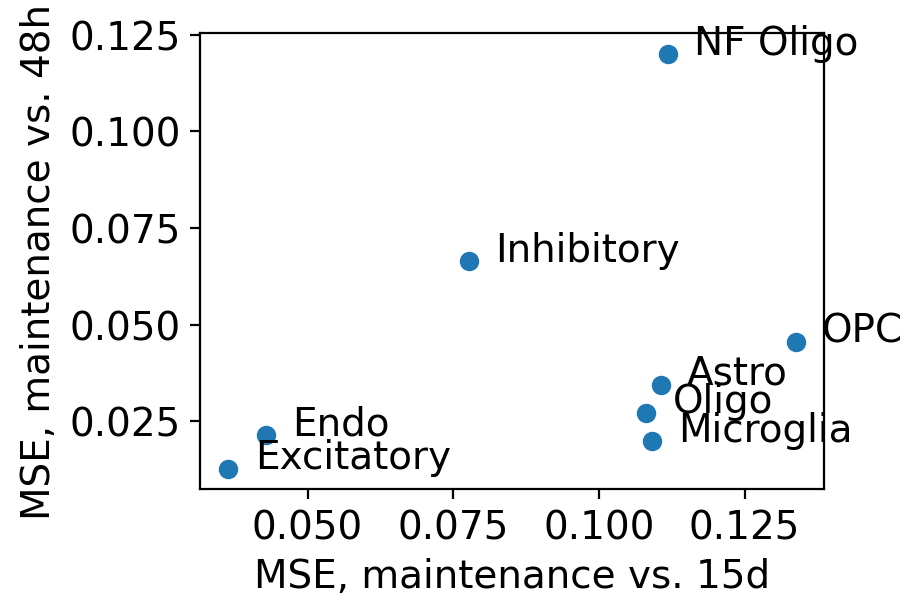

In [116]:
plt.figure(figsize=(4,3))
rho = spearmanr(diff['15d'].values, diff['48h'].values)[0]
plt.scatter(diff['15d'], diff['48h'])

offset = .0045
for i, txt in enumerate(diff.index):
    plt.annotate(txt, (diff['15d'].iloc[i]+offset, diff['48h'].iloc[i]))

# plt.title('Scatter plot of Mean Augur Score vs 48h')
# plt.xlabel('Mean Augur Score')
plt.ylabel('MSE, maintenance vs. 48h')
plt.xlabel('MSE, maintenance vs. 15d')
plt.grid(None)
# plt.legend()
plt.show()